# Blent : Validation and Interpretability

## Model validation


In [1]:
import os
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

d = os.getcwd()
df = pd.read_csv(d+"\\data\\sample.csv")

sns.set()

model = joblib.load(d+"\\data\\model.pkl")
X_train = pd.read_csv(d+"\\data\\X_train.csv")
X_test = pd.read_csv(d+"\\data\\X_test.csv")
y_train = pd.read_csv(d+"\\data\\y_train.csv").values.flatten()
y_test = pd.read_csv(d+"\\data/y_test.csv").values.flatten()

y_prob = model.predict_proba(X_test)

C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/lo

In [2]:
model

LGBMClassifier(colsample_bytree=0.6184196030878234,
               learning_rate=0.2191490946282981, max_depth=6,
               num_iterations=200, num_leaves=10, reg_alpha=4, reg_lambda=4,
               subsample=0.5513404748843299)

Let's plot the densities for each class to check whether the model classifies each class in a good way

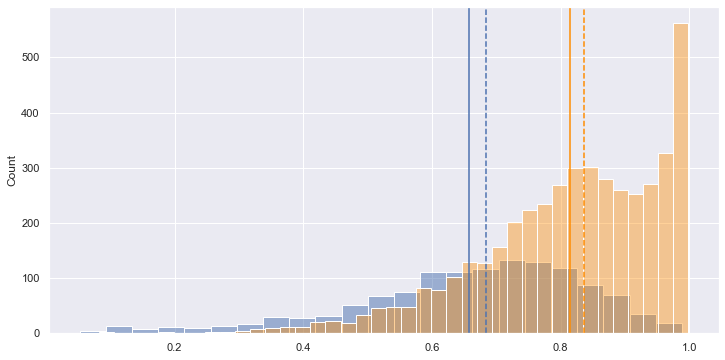

In [3]:
plt.figure(figsize=(12, 6))

sns.histplot(y_prob[y_test == 0, 1], alpha=0.5)
plt.axvline(np.median(y_prob[y_test == 0, 1]), 0,1, linestyle="--", label="Median Class 0")
plt.axvline(np.mean(y_prob[y_test == 0, 1]), 0,1, linestyle="-", label="Mean Class 0")

sns.histplot(y_prob[y_test == 1, 1], color="darkorange", alpha=0.4)
plt.axvline(np.median(y_prob[y_test == 1, 1]), 0, 1, linestyle="--", color="darkorange", label="Median Class 1")
plt.axvline(np.mean(y_prob[y_test == 1, 1]), 0, 1, linestyle="-", color="darkorange", label="Mean Class 1")

plt.show()

In [13]:
y_prob[:15]

array([[0.44370034, 0.55629966],
       [0.0813049 , 0.9186951 ],
       [0.06890243, 0.93109757],
       [0.1175694 , 0.8824306 ],
       [0.39761302, 0.60238698],
       [0.00379363, 0.99620637],
       [0.01955063, 0.98044937],
       [0.66683484, 0.33316516],
       [0.4376001 , 0.5623999 ],
       [0.07617904, 0.92382096],
       [0.12940822, 0.87059178],
       [0.25794652, 0.74205348],
       [0.36973217, 0.63026783],
       [0.33210462, 0.66789538],
       [0.25828128, 0.74171872]])

In [16]:
y_test[:15]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

We notice that the positive class is rather well classified. However, we see that we have many probs > 0.5 for negative class.

Let's plt again the Calibration Curve

In [17]:
y_prob[y_test == 1, 1][:15]

array([0.55629966, 0.9186951 , 0.93109757, 0.8824306 , 0.60238698,
       0.99620637, 0.98044937, 0.5623999 , 0.92382096, 0.87059178,
       0.74205348, 0.63026783, 0.66789538, 0.74171872, 0.96168365])

<function matplotlib.pyplot.show(*args, **kw)>

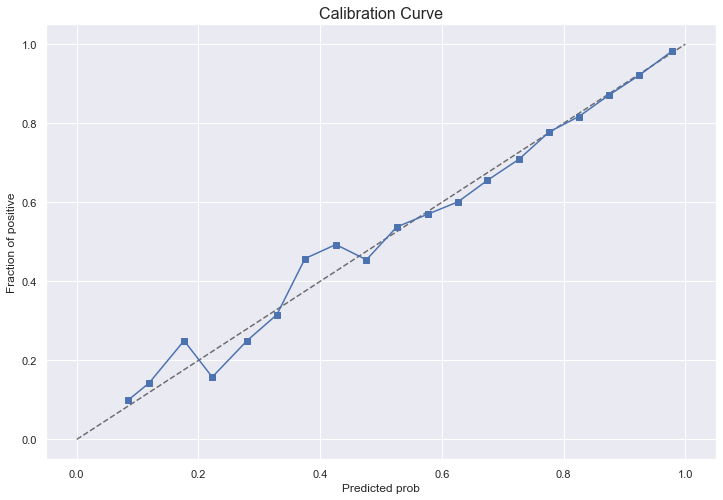

In [82]:
from sklearn.calibration import calibration_curve

fraction_of_pos, mean_pred_value = calibration_curve(y_test, y_prob[:,1], n_bins=20)

plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], "k--", label = "Perfectly calibrated", alpha = 0.6)
plt.plot(mean_pred_value, fraction_of_pos,"s-", label = "Model")
plt.title("Calibration Curve", fontsize = 16)
plt.ylabel("Fraction of positive")
plt.xlabel("Predicted prob")

plt.show

Bien que la courbe de calibration ne soit pas choquante, nous observons sur les densités des classes que les deux distributions sont asymétriques avec une moyenne à gauche par rapport à la médiane, traduisant d'un étalement vers la gauche. Bien que ce soit attendu pour la classe positive, cela l'est moins pour la classe négative. En effet, cette dernière devrait, pour un modèle parfait, être étalée vers la droite, donc la majorité des observations sont à gauche.

En soit, ce graphe ne bloque pas la validation du modèle, elle traduit simplement de manière visuelle que le modèle a plus de difficultés à prédire avec une forte confiance des probabilités basses.

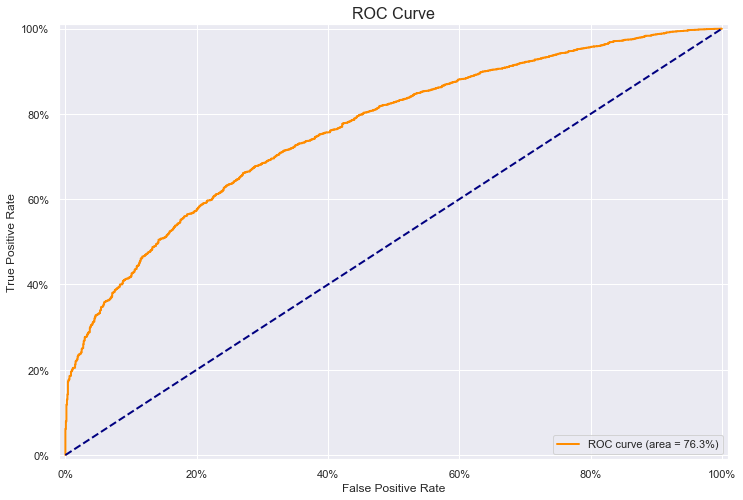

In [83]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:2.1f}%)'.format(auc(fpr, tpr) * 100))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.title("ROC Curve", fontsize=16)
plt.legend(loc="lower right")

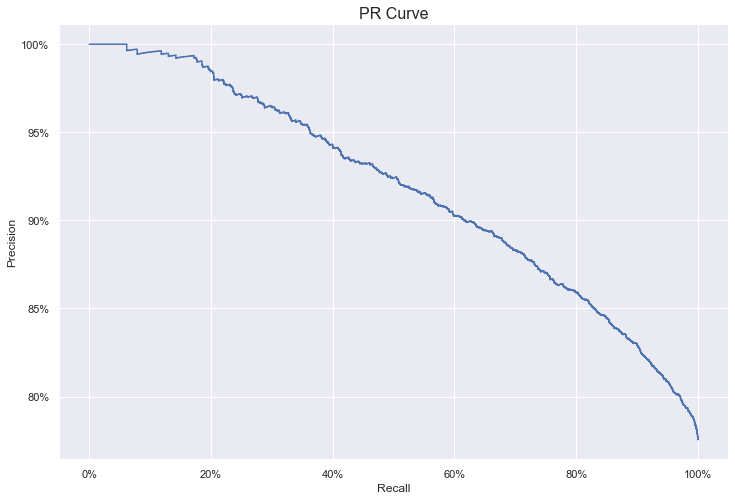

In [84]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

import matplotlib.pyplot as plt

y_pred = model.predict_proba(X_test)

plt.figure(figsize=(12,8))
prec, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1], pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=plt.gca())
plt.title("PR Curve", fontsize=16)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.show()

## Interpretability

In [91]:
import shap

# L'objet Explainer
explainer = shap.TreeExplainer(model)
X_shap = X_test.copy()
shap_values = explainer.shap_values(X_shap)[1]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


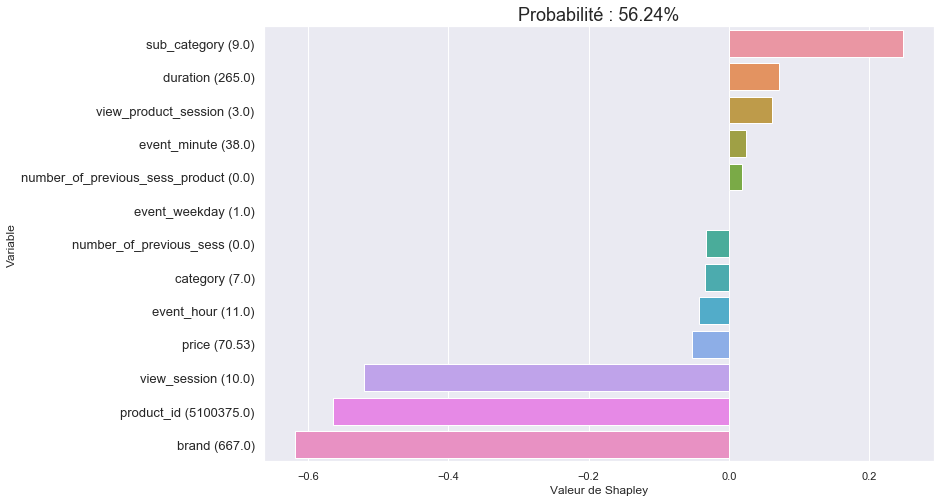

In [119]:
# Cette fonction permet d'afficher les valeurs de Shapley sous forme de diagramme en bâtons
def plot_shapley_values(index):
    shap_df = pd.DataFrame.from_dict({
        'Variable': X_shap.columns + " (" + X_shap.iloc[index, :].values.astype(str) + ")",
        'Valeur de Shapley': shap_values[index, :]
    })

    # Pour rappel, la prédiction est égale à la somme des valeurs de Shapley + la valeur moyenne
    prob = explainer.expected_value[1] + shap_df['Valeur de Shapley'].sum()
    prob = 1 / (1 + np.exp(-prob))

    plt.figure(figsize=(12,8))
    sns.barplot(
        y='Variable',
        x='Valeur de Shapley',
        data=shap_df.sort_values('Valeur de Shapley', ascending=False)
    )
    plt.title(
        "Probabilité : {:2.2f}%".format(prob * 100),
        fontsize=18
    )
    plt.yticks(fontsize=13)
    
plot_shapley_values(8)

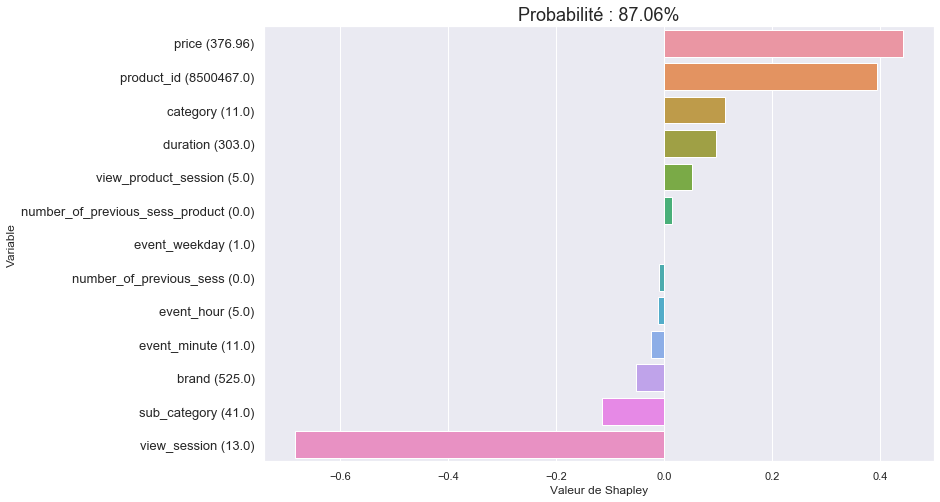

In [120]:
plot_shapley_values(10)

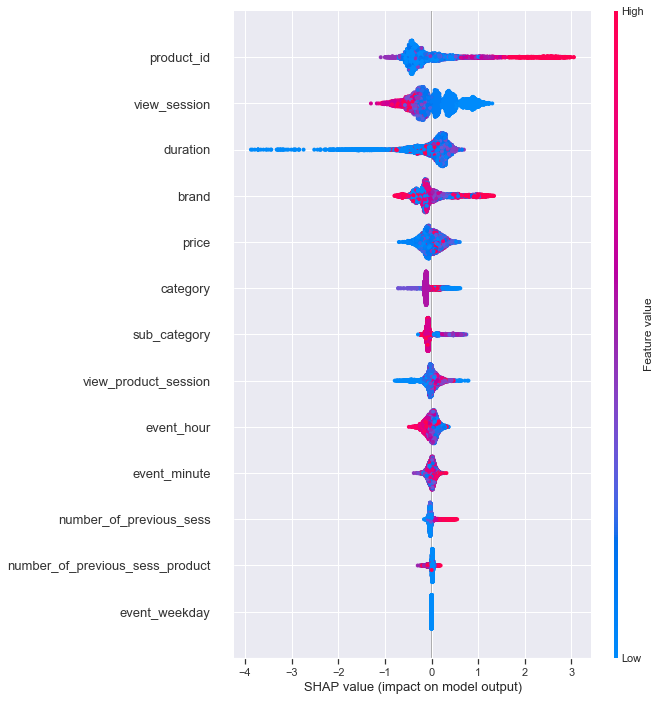

In [121]:
shap.summary_plot(shap_values, X_shap, plot_size=0.8)

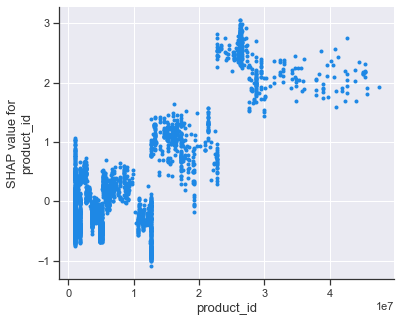

In [122]:
shap.dependence_plot("product_id", shap_values, X_shap, interaction_index=None)

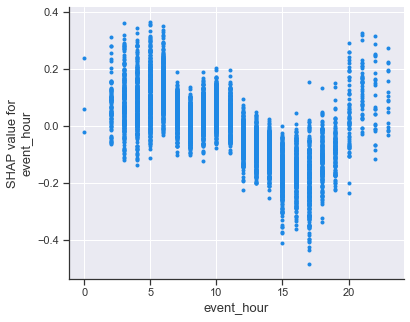

In [124]:
shap.dependence_plot("event_hour", shap_values, X_shap, interaction_index=None)